# 1 Import packages

In [1]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import allel
import pandas as pd
from collections import Counter
import umap
import seaborn as sns

%matplotlib inline   
from matplotlib import pyplot as plt

In [2]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=420)

# 2 Data preprocessing

## 2.1 Read in HLA phenotype data table

In [3]:
hla_df = pd.read_csv('20181129_HLA_types_full_1000_Genomes_Project_panel.txt', delimiter='\t', index_col='Sample ID')
hla_df

,Region,Population,HLA-A 1,HLA-A 2,HLA-B 1,HLA-B 2,HLA-C 1,HLA-C 2,HLA-DQB1 1,HLA-DQB1 2,HLA-DRB1 1,HLA-DRB1 2
Sample ID,,,,,,,,,,,,
HG01879,AFR,ACB,23:01,68:02,13:02,42:01,08:04,17:01,02:02,04:02,03:02,09:01
HG01880,AFR,ACB,33:03,68:02,40:06,42:01,12:02,17:01,02:01,03:04,03:01,11:06
HG01882,AFR,ACB,23:01,34:02,07:02,44:50,04:01,07:02,06:02,06:02,15:03,15:03
HG01883,AFR,ACB,02:01,68:02,53:01,44:03,04:01,04:01,02:02,06:02,13:03,15:03
HG01885,AFR,ACB,03:01,33:03,35:01,35:01,04:01,07:18,02:02,03:19,13:04,07:01
...,...,...,...,...,...,...,...,...,...,...,...,...
HG04114,SAS,STU,02:01,24:02,52:01,55:01,01:02,12:02,03:02,06:03,13:01,04:03
HG04127,SAS,STU,02:11,24:02,15:05,52:01,03:03,12:02,06:09,06:09,13:01,13:02
HG04210,SAS,STU,02:01,24:02,15:25,35:01,04:01,07:26,05:02,06:03,13:01,14:02


## 2.2 Read in VCF files with scikit-allel

In [4]:
callset = allel.read_vcf('ALL.chr6.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz', region='6:29677984-33485635')

In [5]:
gt = allel.GenotypeArray(callset['calldata/GT'])
gt

<GenotypeArray shape=(133720, 2504, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

## 2.3 Filter away multiallelic variants and variants with fewer than 10 instances

In [6]:
ac = gt.count_alleles()[:]
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 9) 
gf = gt.compress(flt, axis=0)
gf

<GenotypeArray shape=(71906, 2504, 2) dtype=int8>
1/1 0/1 0/1 1/1 0/0 ... 1/1 1/1 0/1 0/1 0/1
1/0 0/1 0/1 1/1 0/0 ... 0/1 1/1 0/0 0/0 0/1
1/0 0/1 0/1 1/1 0/0 ... 0/1 1/1 0/0 0/0 0/1
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [7]:
gn = np.array(gf)
num_ones = gn.sum()
print('Sparsity in genotype data: %0.4f' % (1 - num_ones / np.prod(gn.shape)))
print(gn.shape)

Sparsity in genotype data: 0.7880
(71906, 2504, 2)


## 2.3 Make label tensors

In [8]:
genes = ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DQB1', 'HLA-DRB1']

num_samples = len(callset['samples'])

hla_serotypes_1 = []
hla_serotypes_2 = []

hla_fourdigits_1 = []
hla_fourdigits_2 = []

bool_index = np.array(num_samples * [True])

for gene in genes:

    hla_serotype_1 = []
    hla_fourdigit_1 = []
    hla_serotype_2 = []
    hla_fourdigit_2 = []
    for i in range(num_samples):
        sample = callset['samples'][i]
        
        fourdigit_1 = hla_df.loc[sample, '%s 1' % gene]
        if isinstance(fourdigit_1, str) and len(fourdigit_1) == 5 and fourdigit_1[2] == ':':
            hla_serotype_1.append(fourdigit_1[0:2])
            hla_fourdigit_1.append(fourdigit_1)
        else:
            hla_serotype_1.append(None)
            hla_fourdigit_1.append(None)
            bool_index[i] = False

        fourdigit_2 = hla_df.loc[sample, '%s 2' % gene]
        if isinstance(fourdigit_2, str) and len(fourdigit_2) == 5 and fourdigit_2[2] == ':':
            hla_serotype_2.append(fourdigit_2[0:2])
            hla_fourdigit_2.append(fourdigit_2)
        else:
            hla_serotype_2.append(None)
            hla_fourdigit_2.append(None)
            bool_index[i] = False

    hla_serotypes_1.append(hla_serotype_1)
    hla_fourdigits_1.append(hla_fourdigit_1)
    hla_serotypes_2.append(hla_serotype_2)
    hla_fourdigits_2.append(hla_fourdigit_2)

num_usable_samples = bool_index.sum()
region = hla_df.loc[callset['samples'], 'Region'][bool_index]
population = hla_df.loc[callset['samples'], 'Population'][bool_index]
samples = callset['samples'][bool_index]
gnr = gn[:, bool_index, :]

for i in range(len(genes)):
    hla_serotypes_1[i] = np.array(hla_serotypes_1[i], dtype=str)[bool_index]
    hla_fourdigits_1[i] = np.array(hla_fourdigits_1[i], dtype=str)[bool_index]
    hla_serotypes_2[i] = np.array(hla_serotypes_2[i], dtype=str)[bool_index]
    hla_fourdigits_2[i] = np.array(hla_fourdigits_2[i], dtype=str)[bool_index]

In [9]:
onehotencoder_serotypes = OneHotEncoder(sparse=False)
y_serotypes = onehotencoder_serotypes.fit_transform(np.vstack([np.array(hla_serotypes_1).T, np.array(hla_serotypes_2).T]))
y_serotypes = (y_serotypes[:num_usable_samples] + y_serotypes[num_usable_samples:])

onehotencoder_fourdigits = OneHotEncoder(sparse=False)
y_fourdigits = onehotencoder_fourdigits.fit_transform(np.vstack([np.array(hla_fourdigits_1).T, np.array(hla_fourdigits_2).T]))
y_fourdigits = (y_fourdigits[:num_usable_samples] + y_fourdigits[num_usable_samples:])

## 2.4 Make training tensors

In [10]:
x = gnr.transpose(1, 0, 2).sum(axis=-1)
x.shape

(2030, 71906)

In [11]:
y = y_fourdigits[:, 0] / 2
y.shape

(2030,)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

# 3 Unsupervised learning

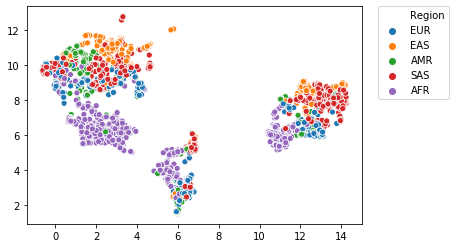

In [13]:
coords1, model1 = allel.pca(x.T, n_components=69, scaler='patterson')
reducer = umap.UMAP()
embedding = reducer.fit_transform(coords1)
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=region)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

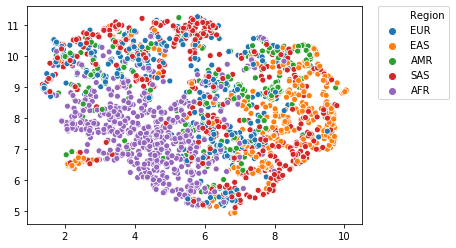

In [14]:
pca = PCA(n_components=69)
y_r = pca.fit(y_serotypes).transform(y_serotypes)
reducer = umap.UMAP()
embedding = reducer.fit_transform(y_r)
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=region)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

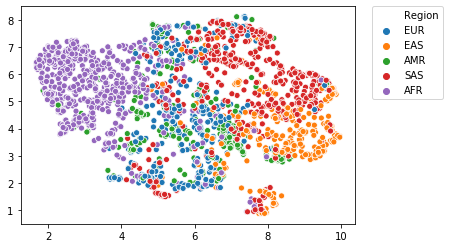

In [15]:
pca = PCA(n_components=69)
y_r = pca.fit(y_fourdigits).transform(y_fourdigits)
reducer = umap.UMAP()
embedding = reducer.fit_transform(y_r)
ax = sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=region)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# 4 Train model

In [16]:
parameters = {
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=128)

[1]	valid_0's cross_entropy: 0.303309
[2]	valid_0's cross_entropy: 0.283699
[3]	valid_0's cross_entropy: 0.269011
[4]	valid_0's cross_entropy: 0.255176
[5]	valid_0's cross_entropy: 0.243048
[6]	valid_0's cross_entropy: 0.233304
[7]	valid_0's cross_entropy: 0.224325
[8]	valid_0's cross_entropy: 0.216608
[9]	valid_0's cross_entropy: 0.2099
[10]	valid_0's cross_entropy: 0.204276
[11]	valid_0's cross_entropy: 0.198944
[12]	valid_0's cross_entropy: 0.193962
[13]	valid_0's cross_entropy: 0.189305
[14]	valid_0's cross_entropy: 0.18492
[15]	valid_0's cross_entropy: 0.181099
[16]	valid_0's cross_entropy: 0.17752
[17]	valid_0's cross_entropy: 0.174529
[18]	valid_0's cross_entropy: 0.171807
[19]	valid_0's cross_entropy: 0.168951
[20]	valid_0's cross_entropy: 0.166686
[21]	valid_0's cross_entropy: 0.164173
[22]	valid_0's cross_entropy: 0.161829
[23]	valid_0's cross_entropy: 0.159685
[24]	valid_0's cross_entropy: 0.157913
[25]	valid_0's cross_entropy: 0.156096
[26]	valid_0's cross_entropy: 0.154657

# 4 Evaluate

In [17]:
y_predict = model.predict(x_test)

Text(0, 0.5, 'Precision')

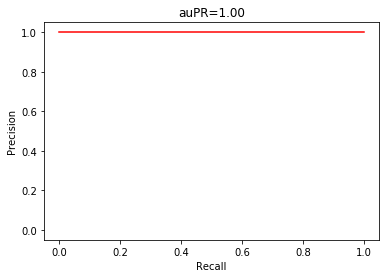

In [18]:
p, r, _ = precision_recall_curve(y_test > 0, y_predict)
aupr = auc(r, p)
plt.plot(r, p, 'r-')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.title('auPR=%0.2f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')

Text(0, 0.5, 'TPR')

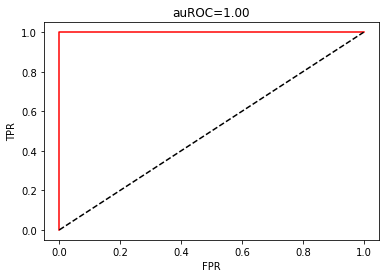

In [19]:
fpr, tpr, _ = roc_curve(y_test > 0, y_predict)
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r-')
plt.plot([0,1], [0,1], 'k--')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.title('auROC=%0.2f' % auroc)
plt.xlabel('FPR')
plt.ylabel('TPR')

Text(0, 0.5, 'True value')

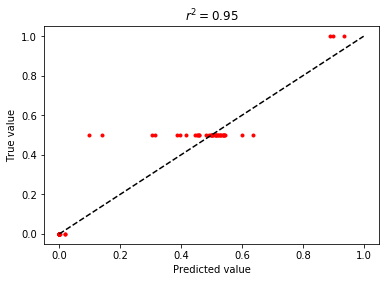

In [20]:
r = r2_score(y_test, y_predict)
plt.plot(y_predict, y_test, 'r.')
plt.plot([0,1], [0,1], 'k--')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.title('$r^2=$%0.2f' % r)
plt.xlabel('Predicted value')
plt.ylabel('True value')

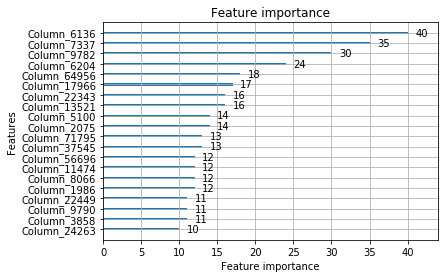

In [21]:
lgb.plot_importance(model, max_num_features=20)

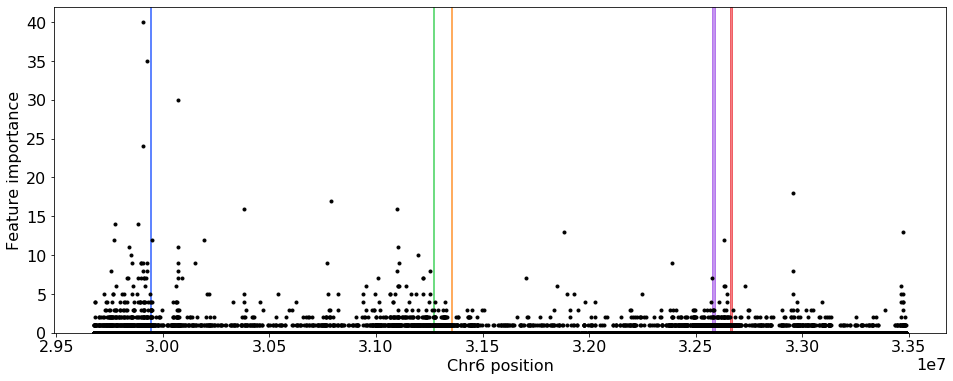

In [22]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()

i = model.feature_importance()
ax.plot(callset['variants/POS'][flt], i, 'k.')

a_start = 29941260
a_stop = 29945884

b_start = 31353875
b_stop = 31357179

c_start = 31268749
c_stop = 31272086

dqb1_start = 32659467
dqb1_stop = 32668383

drb1_start = 32578769
drb1_stop = 32589848

cp = sns.color_palette('bright')

ax.axvspan(a_start, a_stop, alpha=0.5, color=cp[0])
ax.axvspan(b_start, b_stop, alpha=0.5, color=cp[1])
ax.axvspan(c_start, c_stop, alpha=0.5, color=cp[2])
ax.axvspan(dqb1_start, dqb1_stop, alpha=0.5, color=cp[3])
ax.axvspan(drb1_start, drb1_stop, alpha=0.5, color=cp[4])

plt.ylim(0,42)
plt.xlabel('Chr6 position')
plt.ylabel('Feature importance')


plt.savefig('importance.jpg')

# 5 Feature selection

In [23]:
x_reduced = x[:, i > 10]
x_reduced.shape

(2030, 19)

In [24]:
x_reduced_train, x_reduced_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.1, random_state=42)
train_reduced_data = lgb.Dataset(x_reduced_train, label=y_train)
test_reduced_data = lgb.Dataset(x_reduced_test, label=y_test)

In [25]:
parameters = {
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model_reduced = lgb.train(parameters,
                  train_reduced_data,
                  valid_sets=test_reduced_data,
                  num_boost_round=128)

[1]	valid_0's cross_entropy: 0.302666
[2]	valid_0's cross_entropy: 0.282763
[3]	valid_0's cross_entropy: 0.265734
[4]	valid_0's cross_entropy: 0.25292
[5]	valid_0's cross_entropy: 0.244122
[6]	valid_0's cross_entropy: 0.234483
[7]	valid_0's cross_entropy: 0.226294
[8]	valid_0's cross_entropy: 0.218956
[9]	valid_0's cross_entropy: 0.212426
[10]	valid_0's cross_entropy: 0.206466
[11]	valid_0's cross_entropy: 0.201359
[12]	valid_0's cross_entropy: 0.196541
[13]	valid_0's cross_entropy: 0.192217
[14]	valid_0's cross_entropy: 0.187925
[15]	valid_0's cross_entropy: 0.18405
[16]	valid_0's cross_entropy: 0.180789
[17]	valid_0's cross_entropy: 0.17791
[18]	valid_0's cross_entropy: 0.17554
[19]	valid_0's cross_entropy: 0.172621
[20]	valid_0's cross_entropy: 0.170009
[21]	valid_0's cross_entropy: 0.168214
[22]	valid_0's cross_entropy: 0.165783
[23]	valid_0's cross_entropy: 0.163575
[24]	valid_0's cross_entropy: 0.161544
[25]	valid_0's cross_entropy: 0.159901
[26]	valid_0's cross_entropy: 0.158228

In [26]:
y_reduced_predict = model_reduced.predict(x_reduced_test)

Text(0.5, 0, 'Predicted HLA-A*01:01 copy number')

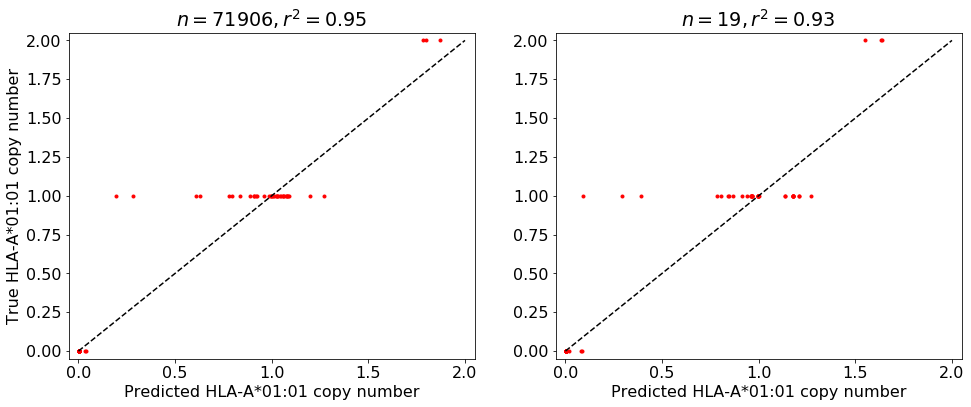

In [27]:
plt.subplot(121)
r = r2_score(y_test, y_predict)
plt.plot(2*y_predict, 2*y_test, 'r.')
plt.plot([0,2], [0,2], 'k--')
plt.xlim(-0.05, 2.05)
plt.ylim(-0.05, 2.05)
plt.title('$n=%i, r^2=$%0.2f' % (x.shape[1], r))
plt.xlabel('Predicted HLA-A*01:01 copy number')
plt.ylabel('True HLA-A*01:01 copy number')

plt.subplot(122)
r = r2_score(y_test, y_reduced_predict)
plt.plot(2*y_reduced_predict, 2*y_test, 'r.')
plt.plot([0,2], [0,2], 'k--')
plt.xlim(-0.05, 2.05)
plt.ylim(-0.05, 2.05)
plt.title('$n=%i, r^2=$%0.2f' % (x_reduced.shape[1], r))
plt.xlabel('Predicted HLA-A*01:01 copy number')
#plt.ylabel('True value')